## Aprendizaje Profundo: Tarea 1 - Ejercicio 2
### Samuel López Ruiz
---
Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria
presuponiendo una red densa con dos capas ocultas y la función de pérdida de entropía cruzada
binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena
y evalúa la red en algún conjunto de datos.

### Arquitectura 
La arquitectura de la red neuronal consiste de 2 capas ocultas con funciones de activación sigmoide. La siguiente figure presenta la arquitectura. 
<img src="img\NN_np.png"/>

### Nomenclatura
- $g()$ funcion de activación de los nodos en capas ocultas
- $g_o()$ función de activación de los nodos en la última capa
- $k$ numero de capa
- $j$ número de neurona
- $i$ número de entrada

La salida de una neurona está definida por 
$$o^k_j = g(a^k_j)$$
### Pesos
Para simplificar los cálculos y la programación, se considera que a los pesos $b$ como una entrada adicional con constante 1. Esto significa que la salida de suma-multiplicación se puede expresar asi:
$$a_i^k=b_i^k+\sum_{j=1}^{r_{k-1}} w^k_{ji}o^{k-1}_j=\sum_{j=0}^{r_{k-1}} w^k_{ji}o^{k-1}_j$$
donde $k$ es el número de la capa, $r_{k}$ son el número de neuronas por capa, $w_{ji}$ es el peso correspondiente a la neurona $j$ y a la entrada $i$ y $o^{k-1}_j$ es la salida después de la función de activación de la neurona $j$ y la capa $k-1$. <br>
Notese como cambió la sumantoria de $j=1$ a $j=0$ por la incorporación del peso como una entrada. 

### Gradiente del Error
Para actualizar los pesos (el sesgo ya está incluido en los pesos), es necesario computar el gradiente del error con respecto a cada uno de los pesos. Usando la regla de la cadena, podemos expresar la derivada parcial como:
$$\frac{\partial E}{\partial w^k_{ij}} = \frac{\partial E}{\partial a^k_{j}}\frac{\partial a^k_j}{\partial w^k_{ij}}$$
Sabemos que $$\frac{\partial a^k_j}{\partial w^k_{ij}} = o^{k-1}_i$$
y por convención el gradiente del error con respecto a la entrada se denomina:
$$\delta^k_j=\frac{\partial E}{\partial a^k_{j}}$$

Esto nos lleva a la expresión:
$$\frac{\partial E}{\partial w^k_{ij}} = \delta^k_j o^{k-1}_i $$

Para la última capa tenemos que el error con respecto a la entrada se puede definir como:
$$\delta^m_1 = g'_0(a_1^m)(\hat{y}-y)$$
donde $g'_0(a_1^m)$ es la derivada de la función de activación de la última capa evaluada en $a^m_1$ y $m$ es la úlitma capa

### Gradiente capas intermedias
Para las capas intermedias $(1<k<m)$   el error se puede escribir como:
$$\delta^k_j = \frac{\partial E}{\partial a^k_{j}} = \sum^{r^{k+1}}_{l=1} \frac{\partial E}{\partial a^{k+1}_{l}}\frac{\partial a^{k+1}_j}{\partial a^k_{j}}$$ 
Como podemos ver, se toma en cuenta el error de la capa siguiente $k+1$. 
Saltandonos varios pasos se llega a la siguiente expresión:
$$\delta^k_j = g'(a^k_j) \sum^{r^{k+1}}_{l=1}w^{k+1}_{jl}\delta^{k+1}_l$$ 
donde el error de la neurona $j$ en la capa $k$ está en función de la derivada de la función de activación de la neurona evaluada en $a^k_j$ y la suma-producto de los pesos de la siguiente capa y el error de la siguiente capa. <br>
De aquí que viene el termino 'retro-propagación' porque para calcular el error de la capa $k$ se tiene que calcular primero el error de la capa $k+1$, lo que significa que el cómputo se realiza del final al inicio. 

### Selección conveniente de $g()$
Sabemos que la derivada de la función de activación sigmoide es:
$$g'(x) = \frac{\partial \sigma (x)}{\partial x} = \sigma(x)(1-\sigma(x))$$

Y sabemos que:
$$o^k_j = g(a^k_j) = \sigma(a^k_j)$$
Esto significa que la ecuación del error para la capas ocultas se puede simplificar de la siguiente forma:
$$\delta^k_j = o^k_j(1-o^k_j) \sum^{r^{k+1}}_{l=1}w^{k+1}_{jl}\delta^{k+1}_l$$ 

Con esta ecuación queda claro que se necesita primero calcular la salida de la capa $o^k_j$ en el 'forward-pass' y también se necesita el error de la siguiente capa $\delta^{k+1}_l$.

### Implementación
Primero definimos la función sigmoide, de entropia curzada binaria y de exactitud. 

In [1]:
import numpy as np

def entropia_cruzada_binaria(y, p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

# define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def exactitud(y, y_predicha):
    return (y == y_predicha).mean() * 100

A continuación definimos el ciclo de retro-propagación considerando un tamaño de lote. Para calcular el gradiente  utilizando un lote de ejemplos, basta con computar el promedio del gradiente a lo largo de los ejemplos. Es decir:
$$\frac{\partial E(X,\Theta)}{\partial w^k_{ij}} = \frac{1}{N}\sum^{N}_{d=1} \frac{\partial E_d}{\partial w^{k}_{ij}}$$ 
Donde N es el tamaño del lote. 

In [2]:

def backpropagation(X, y, num_hidden, batch_size, n_epochs=500, alpha=1):
    n_batch = X.shape[0] // batch_size
    y_hat = []
    
    # inicialización de los pesos W1, W2 y W_out dentro del rango (-1, 1)
    W1 = 2 * np.random.random((X.shape[1] + 1, num_hidden)) - 1
    W2 = 2 * np.random.random((num_hidden + 1, num_hidden)) - 1
    W_out = 2 * np.random.random((num_hidden + 1, 1)) - 1
      
    # variables para guardar la pérdida y la exactitud a lo largo de las epocas
    losses = np.zeros((n_epochs))
    precisions = np.zeros((n_epochs))
    
    for i in range(n_epochs):
        
        for b in range(n_batch):
            # tomamos el lote de ejemplos x con su etiqueta y
            B = X[b*batch_size:b*batch_size+batch_size, :]
            y_batch = y[b*batch_size:b*batch_size+batch_size, :]
            
            # 'forward-pass' para calcular las salidas de cada capa
            # se agrega una columna con entrada 1 para simular el sesgo 
            a_input = np.hstack((np.ones((B.shape[0], 1)), B))
            a_1 = np.hstack((np.ones((B.shape[0], 1)), sigmoid(np.dot(a_input, W1))))
            a_2 = np.hstack((np.ones((B.shape[0], 1)), sigmoid(np.dot(a_1, W2))))
            a_output = sigmoid(np.dot(a_2, W_out))
            y_hat = a_output if b == 0 else np.vstack((y_hat, a_output))
            
            # fase de retro-propagación 
            # el gradiente del error con respecto a la última función de activación
            output_error = a_output - y_batch
            
            # el error para cada una de las capas intermedias
            # se empieza con la última capa hasta llegar a la primera
            error_2 = a_2[:, 1:] * (1 - a_2[:, 1:]) * np.dot(output_error, W_out.T[:, 1:])
            error_1 = a_1[:, 1:] * (1 - a_1[:, 1:]) * np.dot(error_2, W2.T[:, 1:])
            
        
            # cálculo de derivadas parciales a lo largo de todos los ejemplos del lote
            hidden_pd_1 = a_input[:, :, np.newaxis] * error_1[: , np.newaxis, :]
            hidden_pd_2 = a_1[:, :, np.newaxis] * error_2[: , np.newaxis, :]
            output_pd = a_2[:, :, np.newaxis] * output_error[:, np.newaxis, :]
        
            # se calcula el promedio del gardiente a lo largo de los ejemplo 
            total_gradient_1 = np.average(hidden_pd_1, axis=0)
            total_gradient_2 = np.average(hidden_pd_2, axis=0)
            total_out_gradient = np.average(output_pd, axis=0)
        
            # se actualizan los pesos
            W1 += - alpha * total_gradient_1
            W2 += - alpha * total_gradient_2
            W_out += - alpha * total_out_gradient
            
            
        # calcula y guarda la pérdida y exactitud en la época 
        losses[i] = entropia_cruzada_binaria(y, y_hat)
        precisions[i] = exactitud(y, np.round(y_hat))

    return losses, precisions, y_hat

Usamos un set de datos inventados

Salida Después de Entrenamiento: 
[[0.  ]
 [0.99]
 [0.99]
 [0.01]]
Precision: 
100.0


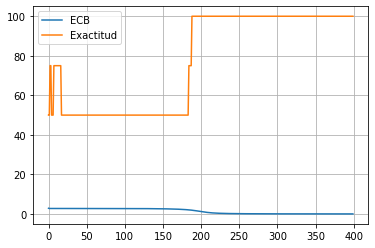

In [3]:
# semilla para garantizar replicabilidad
np.random.seed(1)


# Usamos los datos de la compuerta (XOR)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

# utilizamos 500 epocas, 4 neuronas por capa y un lote de 2
losses, precisions, y_hat = backpropagation(X, y, num_hidden=5, n_epochs=400, batch_size=2, alpha=1)

print("Salida Después de Entrenamiento: \n{}".format(np.round(y_hat, 2)))
print("Precision: \n{}".format(precisions[-1]))


import matplotlib.pyplot as plt
plt.plot(np.arange(losses.size), losses, label='ECB')
plt.plot(np.arange(precisions.size), precisions, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

Se puede comprobar que la red neuronal fue capaz de aprender la compuerta XOR. El error fue disminuyendo a lo largo de las epocas y la exactitud llegó a 100% antes de la epoca 200.